# Starbucks Beverages
Data Cleansing and Analysis in Python

In [1]:
# The first thing to do is import required libraries.
# Pandas is used for data manipulation and cleaning, while matplotlib and seaborn will do the heavy lifting for visualizations.

# Import Libraries

import pandas as pd
import numpy as np
import matplotlib as mb
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
# Import CSV to dataframe, view a sample of the data

sbux_data = pd.DataFrame()
sbux_data = pd.read_csv(r"\starbucks.csv")

# View a small slice of the data
sbux_data.head()




,Beverage_category,Beverage,Beverage_prep,Calories,Total Fat (g),Trans Fat (g),Saturated Fat (g),Sodium (mg),Total Carbohydrates (g),Cholesterol (mg),Dietary Fibre (g),Sugars (g),Protein (g),Vitamin A (% DV),Vitamin C (% DV),Calcium (% DV),Iron (% DV),Caffeine (mg)
0,Coffee,Brewed Coffee,Short,3,0.1,0.0,0.0,0,5,0,0,0,0.3,0%,0%,0%,0%,175
1,Coffee,Brewed Coffee,Tall,4,0.1,0.0,0.0,0,10,0,0,0,0.5,0%,0%,0%,0%,260
2,Coffee,Brewed Coffee,Grande,5,0.1,0.0,0.0,0,10,0,0,0,1.0,0%,0%,0%,0%,330
3,Coffee,Brewed Coffee,Venti,5,0.1,0.0,0.0,0,10,0,0,0,1.0,0%,0%,2%,0%,410
4,Classic Espresso Drinks,Caffè Latte,Short Nonfat Milk,70,0.1,0.1,0.0,5,75,10,0,9,6.0,10%,0%,20%,0%,75


In [3]:
# Check the column headers for inconsistencies

sbux_data.columns

Index(['Beverage_category', 'Beverage', 'Beverage_prep', 'Calories',
       ' Total Fat (g)', 'Trans Fat (g) ', 'Saturated Fat (g)', ' Sodium (mg)',
       ' Total Carbohydrates (g) ', 'Cholesterol (mg)', ' Dietary Fibre (g)',
       ' Sugars (g)', ' Protein (g) ', 'Vitamin A (% DV) ', 'Vitamin C (% DV)',
       ' Calcium (% DV) ', 'Iron (% DV) ', 'Caffeine (mg)'],
      dtype='object')

In [4]:
# We'll remove the leading spaces in our headers. This will make working with the data and reporting on it simpler and cleaner.

sbux_data = sbux_data.rename(columns=lambda x: x.strip())
sbux_data.columns

sbux_data['Beverage Category'] = sbux_data['Beverage_category']
sbux_data['Beverage Prep'] = sbux_data['Beverage_prep']

sbux_data.columns

Index(['Beverage_category', 'Beverage', 'Beverage_prep', 'Calories',
       'Total Fat (g)', 'Trans Fat (g)', 'Saturated Fat (g)', 'Sodium (mg)',
       'Total Carbohydrates (g)', 'Cholesterol (mg)', 'Dietary Fibre (g)',
       'Sugars (g)', 'Protein (g)', 'Vitamin A (% DV)', 'Vitamin C (% DV)',
       'Calcium (% DV)', 'Iron (% DV)', 'Caffeine (mg)', 'Beverage Category',
       'Beverage Prep'],
      dtype='object')

In [5]:
# Now to review basic attributes about the dataframe for our knowledge

pd.DataFrame({
    'count':sbux_data.shape[0],
    'Nulls':sbux_data.isnull().sum(),
    'countUnique':sbux_data.nunique(),
})

,count,Nulls,countUnique
Beverage_category,242,0,9
Beverage,242,0,33
Beverage_prep,242,0,13
Calories,242,0,48
Total Fat (g),242,0,24
Trans Fat (g),242,0,18
Saturated Fat (g),242,0,4
Sodium (mg),242,0,9
Total Carbohydrates (g),242,0,51
Cholesterol (mg),242,0,75


In [6]:
# We'll define a function to identify milk types, then extract that key phrase to a new 'Milk Type' field.

def extract_dairy_type(text, key_phrase):
    pattern = '|'.join(key_phrase)
    match = re.search(pattern, text, flags=re.IGNORECASE)
    if match:
        return match.group(0)
    else:
        return 'DairyFree'


key_phrase = ['2% Milk','Nonfat Milk','Whole Milk','Soymilk']

# Run dairy_extract

sbux_data['Dairy Type'] = sbux_data['Beverage Prep'].apply(lambda x: extract_dairy_type(x, key_phrase))

In [7]:
# Create helper columns to aid in the extraction of size and ounce information from the 'Beverage_prep' column.

sbux_data['Sort'] = sbux_data['Beverage']+sbux_data['Dairy Type']
sbux_data['Rank'] = sbux_data.groupby('Sort')['Calories'].rank(ascending=False)
sbux_data['Sort Count'] = sbux_data.groupby('Sort')['Sort'].transform('count')
sbux_data['Item Count'] = 1

In [8]:
# Some of the 'Beverage_prep' descriptions already include the size. This function will extract that information to a new field.

def determine_menu_size(row):
    sizes = ['Short', 'Tall', 'Grande', 'Venti', 'Doppio', 'Solo']
    
    # Check if Beverage_prep contains any of the predefined sizes
    for size in sizes:
        if size in row['Beverage Prep']:
            return size
    

# Apply the function to create 'MenuSize' column
sbux_data['MenuSize'] = sbux_data.apply(determine_menu_size, axis=1)

In [9]:
# Any description that doesn't already include the size will need to be calculated. 
# The previously created 'Rank' column can be used to assign size based on the calorie content.

def determine_size(row):
    if row['MenuSize']:
        return row['MenuSize']
    else:
        if row['Sort Count'] == 1:
            return 'Grande'
        elif row['Sort Count'] != 1:
            if row['Rank'] == 4.0:
                return 'Short'
            if row['Rank'] == 3.0:
                return 'Tall'
            if row['Rank'] == 2.0:
                return 'Grande'
            if row['Rank'] == 1.0:
                return 'Venti'
            else:
                return 'ERROR'
            
sbux_data['DrinkSize'] = sbux_data.apply(determine_size, axis=1)




In [10]:
# Review dataframe to see changes made

sbux_data.head()

,Beverage_category,Beverage,Beverage_prep,Calories,Total Fat (g),Trans Fat (g),Saturated Fat (g),Sodium (mg),Total Carbohydrates (g),Cholesterol (mg),...,Caffeine (mg),Beverage Category,Beverage Prep,Dairy Type,Sort,Rank,Sort Count,Item Count,MenuSize,DrinkSize
0,Coffee,Brewed Coffee,Short,3,0.1,0.0,0.0,0,5,0,...,175,Coffee,Short,DairyFree,Brewed CoffeeDairyFree,4.0,4,1,Short,Short
1,Coffee,Brewed Coffee,Tall,4,0.1,0.0,0.0,0,10,0,...,260,Coffee,Tall,DairyFree,Brewed CoffeeDairyFree,3.0,4,1,Tall,Tall
2,Coffee,Brewed Coffee,Grande,5,0.1,0.0,0.0,0,10,0,...,330,Coffee,Grande,DairyFree,Brewed CoffeeDairyFree,1.5,4,1,Grande,Grande
3,Coffee,Brewed Coffee,Venti,5,0.1,0.0,0.0,0,10,0,...,410,Coffee,Venti,DairyFree,Brewed CoffeeDairyFree,1.5,4,1,Venti,Venti
4,Classic Espresso Drinks,Caffè Latte,Short Nonfat Milk,70,0.1,0.1,0.0,5,75,10,...,75,Classic Espresso Drinks,Short Nonfat Milk,Nonfat Milk,Caffè LatteNonfat Milk,4.0,4,1,Short,Short


In [11]:
# Drinks can be broadly sorted into their temperature based on title.
# Some drinks could be either hot or iced, but for this initial analysis we'll group by main category.

def determine_temperature(row):
    categories = ['Iced', 'Frappuccino®', 'Smoothies']
    
    # Check if Beverage_prep contains any of the predefined sizes
    for cat in categories:
        if cat in row['Beverage Category']:
            return 'Iced'
    return 'Hot'
        
    

# Apply the function to create 'MenuSize' column
sbux_data['Beverage Temp'] = sbux_data.apply(determine_temperature, axis=1)



In [12]:
# Once we know if a beverage is hot or iced it is possible to appropriately assign the ounces.

def determine_ounces(row):
    if (row['Beverage Temp'] == 'Iced') and (row['DrinkSize'] == 'Venti'):
        return 24
    if row['DrinkSize'] == 'Grande':
        return 16
    if row['DrinkSize'] == 'Tall':
        return 12
    if row['DrinkSize'] == 'Short':
        return 8
    if row['DrinkSize'] == 'Doppio':
        return 2
    if row['DrinkSize'] == 'Solo':
        return 1
    if row['DrinkSize'] == 'Venti' and row['Beverage Temp'] == 'Hot':
        return 20
    else:
        return 'ERROR'
            
sbux_data['Drink Ounces'] = sbux_data.apply(determine_ounces, axis=1)
    

In [13]:
# Add some final cleaning - replace the null and text values to 0.


sbux_data['Caffeine (mg)'] = pd.to_numeric(sbux_data['Caffeine (mg)'], errors='coerce').fillna(0)

In [14]:
# Run our basic table shape again and we see that the null value has been eliminated.

pd.DataFrame({
    'count':sbux_data.shape[0],
    'Nulls':sbux_data.isnull().sum(),
    'countUnique':sbux_data.nunique(),
})

,count,Nulls,countUnique
Beverage_category,242,0,9
Beverage,242,0,33
Beverage_prep,242,0,13
Calories,242,0,48
Total Fat (g),242,0,24
Trans Fat (g),242,0,18
Saturated Fat (g),242,0,4
Sodium (mg),242,0,9
Total Carbohydrates (g),242,0,51
Cholesterol (mg),242,0,75


In [16]:
# We can remove the unneeded columns now, and reduce to only the fields we want.

sbux_data = sbux_data.drop(['Sort','Rank','Sort Count','MenuSize','Beverage_category','Beverage_prep'], axis=1)


In [17]:
# Create a new dataframe with only Grande sizes for our analysis and visualizations.

sbux_grande = sbux_data.loc[sbux_data['DrinkSize'] =='Grande'].reset_index(drop=True)


In [18]:
# Now when we check a sample of our data is is reflecting only size Grande

sbux_grande.head()

,Beverage,Calories,Total Fat (g),Trans Fat (g),Saturated Fat (g),Sodium (mg),Total Carbohydrates (g),Cholesterol (mg),Dietary Fibre (g),Sugars (g),...,Calcium (% DV),Iron (% DV),Caffeine (mg),Beverage Category,Beverage Prep,Dairy Type,Item Count,DrinkSize,Beverage Temp,Drink Ounces
0,Brewed Coffee,5,0.1,0.0,0.0,0,10,0,0,0,...,0%,0%,330.0,Coffee,Grande,DairyFree,1,Grande,Hot,16
1,Caffè Latte,130,0.3,0.2,0.0,5,150,19,0,18,...,40%,0%,150.0,Classic Espresso Drinks,Grande Nonfat Milk,Nonfat Milk,1,Grande,Hot,16
2,Caffè Latte,190,7,3.5,0.2,30,170,19,0,17,...,40%,0%,150.0,Classic Espresso Drinks,2% Milk,2% Milk,1,Grande,Hot,16
3,Caffè Latte,150,5,0.5,0.0,0,130,13,1,8,...,40%,15%,150.0,Classic Espresso Drinks,Soymilk,Soymilk,1,Grande,Hot,16
4,Caffè Mocha (Without Whipped Cream),220,2.5,1.5,0.0,5,125,43,2,34,...,35%,25%,175.0,Classic Espresso Drinks,Grande Nonfat Milk,Nonfat Milk,1,Grande,Hot,16


In [19]:
# Define a dictionary mapping categories to colors
bev_colors = {
    'Classic Espresso Drinks': 'tomato',
    'Tazo® Tea Drinks': 'orange',
    'Frappuccino® Blended Coffee': 'yellow',
    'Signature Espresso Drinks': 'limegreen',
    'Smoothies': 'skyblue',
    'Shaken Iced Beverages': 'mediumblue',
    'Frappuccino® Blended Crème': 'blueviolet',
    'Frappuccino® Light Blended Coffee': 'deeppink',
    'Coffee': 'lightpink',
}

temp_colors = {
    'Hot': 'tomato',
    'Iced': 'deepskyblue',

}

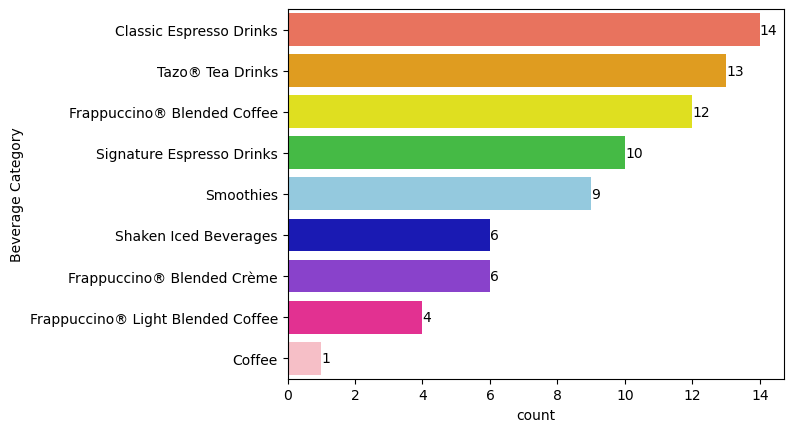

In [20]:
# A simple bar chart to view counts of the drink options


category_counts = sbux_grande['Beverage Category'].value_counts().index.tolist()

ax = sns.countplot(y='Beverage Category', data=sbux_grande, order = category_counts, palette=bev_colors)
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

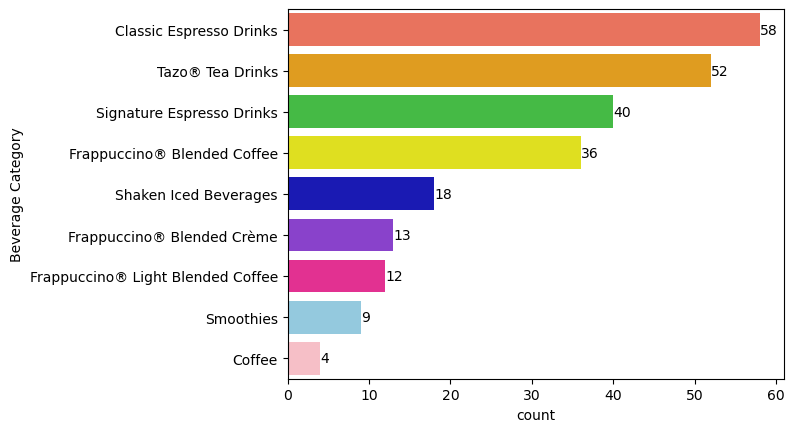

In [21]:
# Another simple bar chart to view counts of the drink options, this time based on our original dataset


category_counts = sbux_data['Beverage Category'].value_counts().index.tolist()

ax = sns.countplot(y='Beverage Category', data=sbux_data, order = category_counts, palette=bev_colors)
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

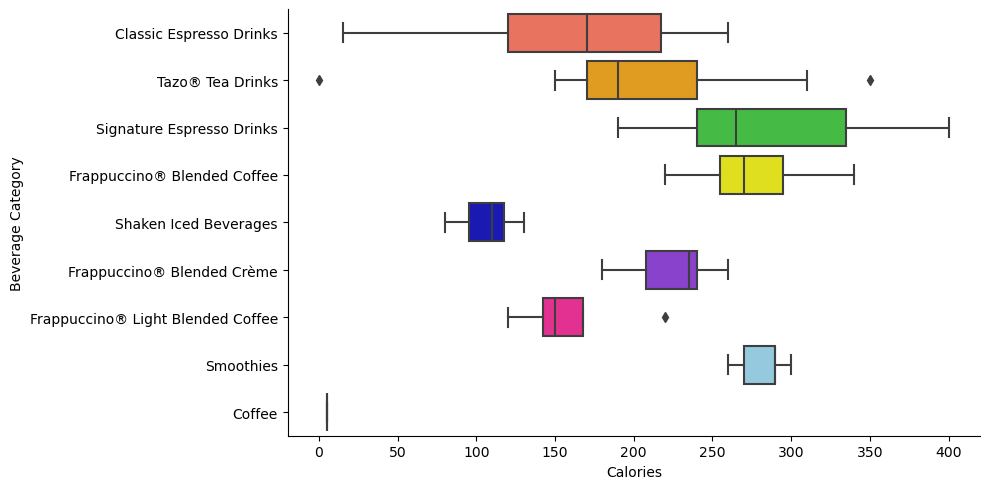

In [23]:
# Now we know our counts by category, but where does that get us? 
# We can drill down into more specific nutirional information. Understanding the calorie content of drinks in each category
# is a good place to start. It appears that drink categories with the most options also have the greatest variation in 
# calorie contents.

sns.catplot(data=sbux_grande,
           x="Calories",
           y="Beverage Category",
           kind = "box",
           aspect = 2,
           order = category_counts,
           palette=bev_colors) 

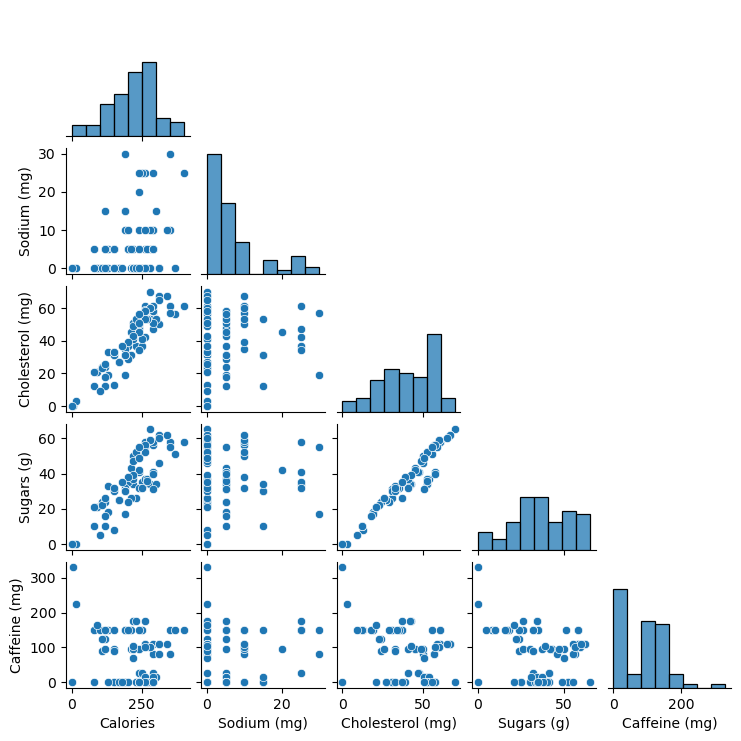

In [24]:
# Let's reduce our dataset to a few of the nutritional facts that I'm most curious about. 
# Once those are skinnied down we'll create a pairplot to check for anything immediately interesting for further investigation.

sbux_nutr = sbux_grande[['Calories','Total Fat (g)','Sodium (mg)','Cholesterol (mg)','Sugars (g)','Caffeine (mg)']]


sns.pairplot(sbux_nutr, height = 1.5, corner = True)

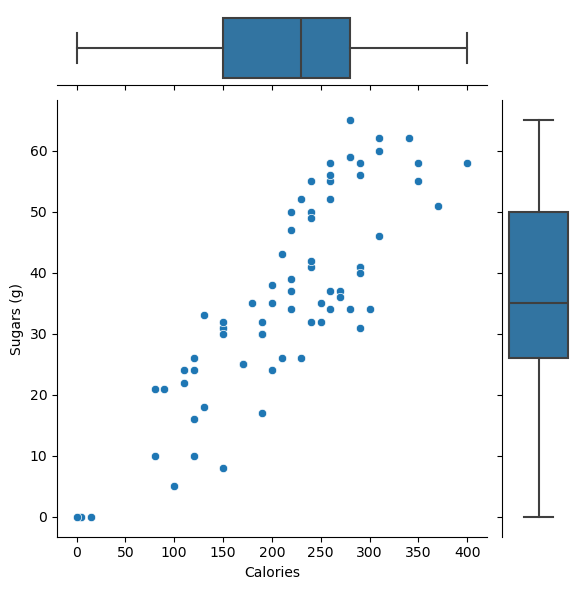

In [25]:
# Sugar and Calories are an obvious place to start. Using a scatter plot paired with box and whiskers we can see
# where these drinks tend to land in relation to each other.


ax = sns.JointGrid(data=sbux_grande, x="Calories", y="Sugars (g)")
ax.plot(sns.scatterplot, sns.boxplot)


<Axes: ylabel='Sugars (g)'>

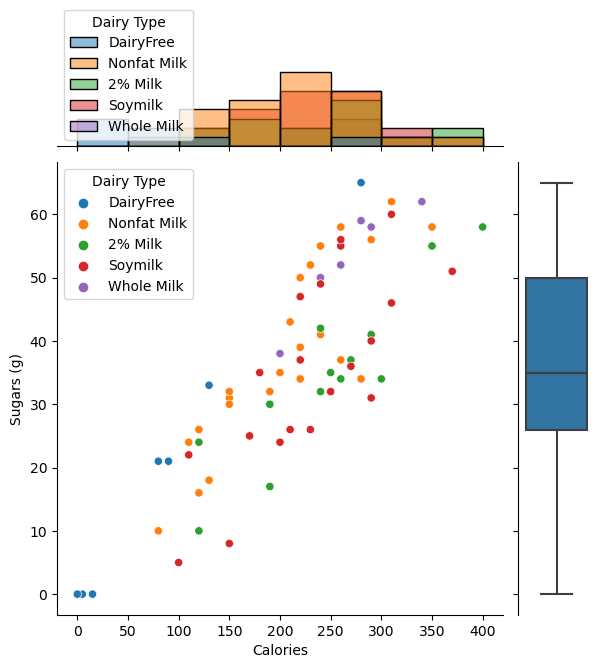

In [27]:
# Let's try a couple variations on this theme, and drill down into further attributes. Dairy and non-dairy milks contain
# added sugars, we'll add a color dimension based on Dairy_Type to check for trends.

g = sns.JointGrid()
x, y = sbux_grande["Calories"], sbux_grande["Sugars (g)"]
sns.scatterplot(x=x,y=y, hue=sbux_grande["Dairy Type"], ax=g.ax_joint)
sns.histplot(x=x, hue=sbux_grande["Dairy Type"], ax=g.ax_marg_x)
sns.boxplot(y=y, hue=sbux_grande["Dairy Type"], ax=g.ax_marg_y)



<Axes: ylabel='Sugars (g)'>

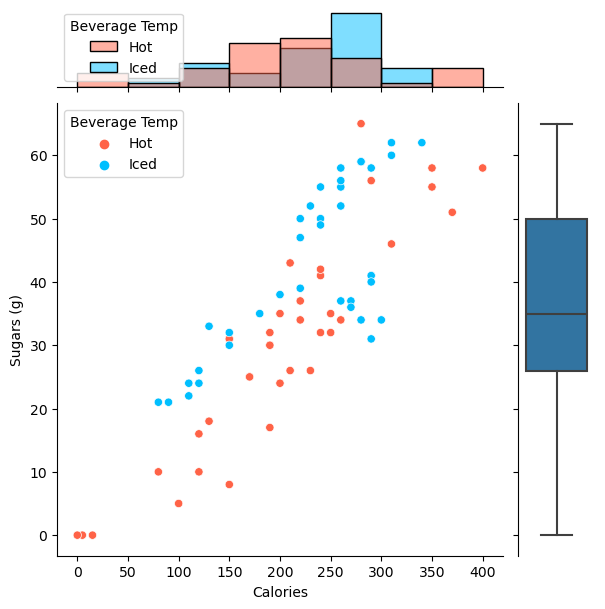

In [28]:
# Dairy didn't indicate anything immediately obvious, other than the fact that ingredients 
# outside of milk and/or coffee must be contributing to the sugar content of these drinks.
# Running this same exercise but with a split based on temperature indicates a stronger trend.

# It would appear on first glance that the Iced Beverages tend to have higher Sugar content, 
# which would in turn push the Calorie count higher.


g = sns.JointGrid()
x, y = sbux_grande["Calories"], sbux_grande["Sugars (g)"]
sns.scatterplot(x=x,y=y, hue=sbux_grande["Beverage Temp"], palette=temp_colors, ax=g.ax_joint)
sns.histplot(x=x, hue=sbux_grande["Beverage Temp"], palette=temp_colors, ax=g.ax_marg_x)
sns.boxplot(y=y, ax=g.ax_marg_y)

<Axes: ylabel='Sugars (g)'>

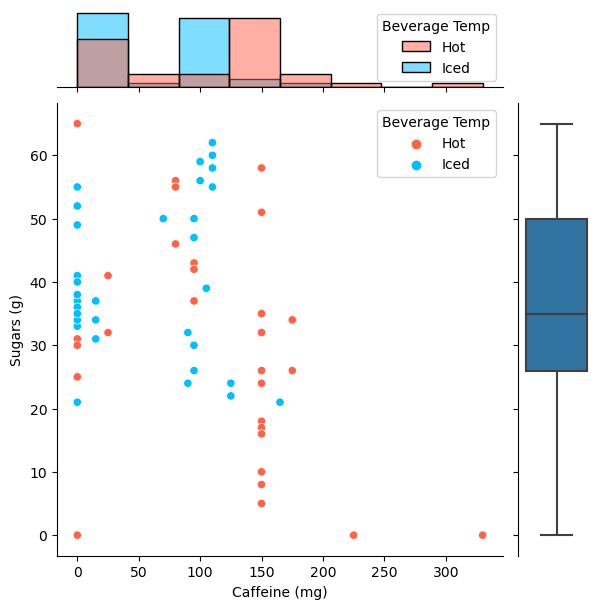

In [29]:
# Caffeine content seems to have a strong banding by total, which would make sense knowing that a shot of espresso is a standard
# size and is used in many drinks. There also seems to be a pattern to Hot vs. Iced drinks and caffeine content.

g = sns.JointGrid()
x, y = sbux_grande["Caffeine (mg)"], sbux_grande["Sugars (g)"]
sns.scatterplot(x=x,y=y, hue=sbux_grande["Beverage Temp"], palette=temp_colors, ax=g.ax_joint)
sns.histplot(x=x, hue=sbux_grande["Beverage Temp"], palette=temp_colors, ax=g.ax_marg_x)
sns.boxplot(y=y, ax=g.ax_marg_y)

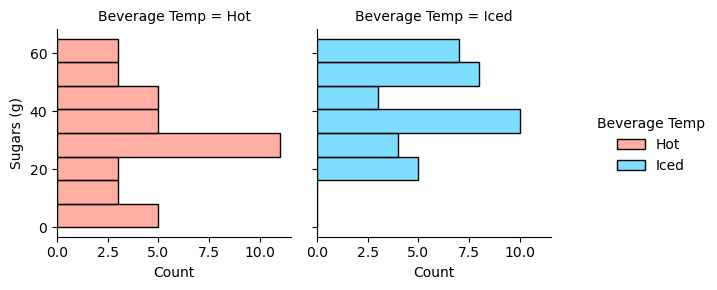

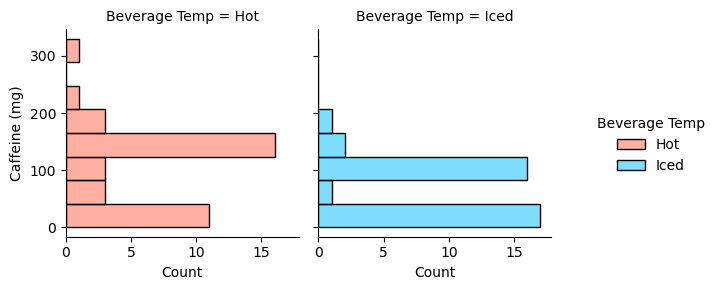

In [30]:
# Each Hot and Iced drinks come in a variety of options by way of caffeination. What about the sugar content?
# This appears to have a somewhat inverse relationship to caffeine, although there is significant overlap in hot drinks.
# Iced drinks semm to be inherently sweetened. There are no iced drinks in our dataset that are free of sugar.

sns.displot(sbux_grande, 
            y="Sugars (g)", 
            col="Beverage Temp", 
            height=3, 
            facet_kws=dict(margin_titles=True),
            hue="Beverage Temp", 
            palette=temp_colors)
sns.displot(sbux_grande, 
            y="Caffeine (mg)", 
            col="Beverage Temp", 
            height=3, 
            facet_kws=dict(margin_titles=True),
            hue="Beverage Temp", 
            palette=temp_colors)
            

In [31]:
# Store the sbux_grande dataframe for use in a fresh jupyter notebook

%store sbux_grande

Stored 'sbux_grande' (DataFrame)
